# Best-DT
A better performing Decision Tree found by performing grid search to find the best combination of hyper-parameters. For this, we experiment with the following parameter values:
+ splitting criterion: gini and entropy
+ maximum depth of the tree: 10 and no maximum
+ minimum number of samples to split an internal node with values of your choice
+ minimum number impurity decrease with values of your choice
+ class weight: None and balanced

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
from utils import config, ProcessDataset, model_utils
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score

## Loading Latin and Greek train and val data.

The data consists of 1025 columns, 1024 columns for each pixel and 1 row specifying the character it represents.
+ Calling helper method to load the dataset of training and validating

In [2]:
Latin_X_Train, Latin_Y_Train, Latin_X_Val, Latin_Y_Val = ProcessDataset.get_Latin_Train_Val()
Greek_X_Train, Greek_Y_Train, Greek_X_Val, Greek_Y_Val = ProcessDataset.get_Greek_Train_Val()

## Experimenting with different DT parameters
+ splitting criterion: gini and entropy
+ maximum depth of the tree: 10 and no maximum
+ minimum number of samples to split an internal node with values of your choice
+ minimum number impurity decrease with values of your choice
+ class weight: None and balanced

### Set up the parameters for grid search

In [3]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, None],
    'min_samples_split': [0.00001, 0.0001, 0.001, 0.01, 0.05, 4],
    'min_impurity_decrease': [0.0001, 0.001, 0.05, 0.1, 0.2, 0.5, 1, 2, 4],
    'class_weight': ['balanced', None]
}

clf_latin = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, n_jobs=-1, cv=10)
clf_greek = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, n_jobs=-1, cv=10)

### Training the DT model

The GridSearch will find the best combination of parameters that yield the best results. 
This can take a while as it is trying out every combination.

In [4]:
clf_latin.fit(Latin_X_Train, Latin_Y_Train)

clf_greek.fit(Greek_X_Train, Greek_Y_Train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, None],
                         'min_impurity_decrease': [0.0001, 0.001, 0.05, 0.1,
                                                   0.2, 0.5, 1, 2, 4],
                         'min_samples_split': [1e-05, 0.0001, 0.001, 0.01, 0.05,
                                               4]})

### Show the best parameters determined by GridSearch

In [5]:
def print_best_params(params, name):
    print('Best estimator for', name, 'DT prediction: ')
    print('\tBest criterion: ', params['criterion'])
    print('\tBest maximum depth: ', params['max_depth'])
    print('\tBest minimum number of samples to split an internal node: ', params['min_samples_split'])
    print('\tBest minimum number impurity decrease: ', params['min_impurity_decrease'])
    print('\tBest class weight: ', params['class_weight'], '\n')

print_best_params(clf_latin.best_estimator_.get_params(), 'latin')
print_best_params(clf_greek.best_estimator_.get_params(), 'greek')


Best estimator for latin DT prediction: 
	Best criterion:  entropy
	Best maximum depth:  None
	Best minimum number of samples to split an internal node:  0.001
	Best minimum number impurity decrease:  0.001
	Best class weight:  None 

Best estimator for greek DT prediction: 
	Best criterion:  gini
	Best maximum depth:  None
	Best minimum number of samples to split an internal node:  0.001
	Best minimum number impurity decrease:  0.001
	Best class weight:  None 



### Export models

In [6]:
from joblib import dump

dump(clf_latin, './models/BEST_DT_clf_latin.joblib')
dump(clf_greek, './models/BEST_DT_clf_greek.joblib')

['./models/BEST_DT_clf_greek.joblib']

### Import models for evaluating

In [7]:
from joblib import load

clf_latin = load('./models/BEST_DT_clf_latin.joblib')
clf_greek = load('./models/BEST_DT_clf_greek.joblib')

### Validating the model with K-Fold Cross-Validation

In [8]:
kfold = KFold(n_splits=10, random_state=100)

results_kfold = cross_val_score(clf_latin, Latin_X_Val, Latin_Y_Val, cv=kfold)
print("Accuracy of latin prediction: %.2f%%" % (results_kfold.mean()*100.0)) 


results_kfold = cross_val_score(clf_greek, Greek_X_Val, Greek_Y_Val, cv=kfold)
print("Accuracy of greek prediction: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy of latin prediction: 27.25%
Accuracy of greek prediction: 71.14%


## Test the models
### Load the test dataset

In [9]:
Latin_X_Test = np.array(ProcessDataset.get_DataFromCSV(config.LATIN_TEST_NOLABEL))
Latin_Y_Test = np.array(ProcessDataset.get_DataFromCSV(config.LATIN_TEST_LABEL))[:,1024]

Greek_X_Test = np.array(ProcessDataset.get_DataFromCSV(config.GREEK_TEST_NOLABEL))
Greek_Y_Test = np.array(ProcessDataset.get_DataFromCSV(config.GREEK_TEST_LABEL))[:,1024]

### Make prediction and export results to `csv` files

In [10]:
Latin_Y_Pred = clf_latin.predict(Latin_X_Test)
pd.DataFrame(Latin_Y_Pred).to_csv(os.path.join(config.OUTPUT_PATH, "BEST-DT-DS1.csv"), header=None)

Greek_Y_Pred = clf_greek.predict(Greek_X_Test)
pd.DataFrame(Greek_Y_Pred).to_csv(os.path.join(config.OUTPUT_PATH, "BEST-DT-DS2.csv"), header=None)

## Assert the accuracy of the models:

### 1. Confusion Matrix

#### Latin Character Predicition Model:

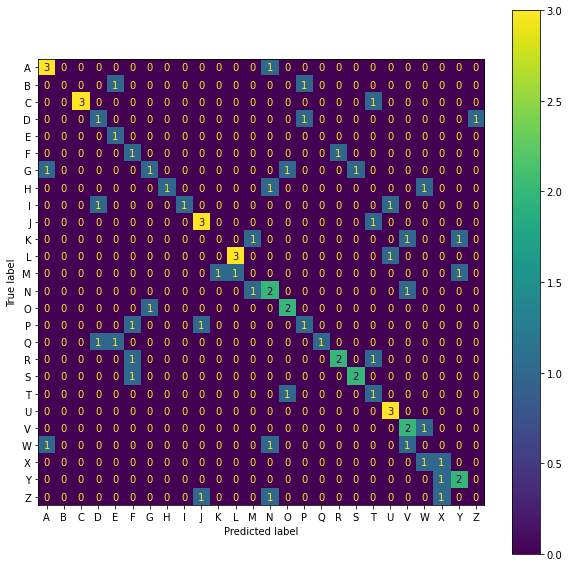

In [11]:
model_utils.show_confusion_matrix(clf_latin, Latin_X_Test, Latin_Y_Test, isGreekLetter=False)

#### Greek Character Prediction Model:

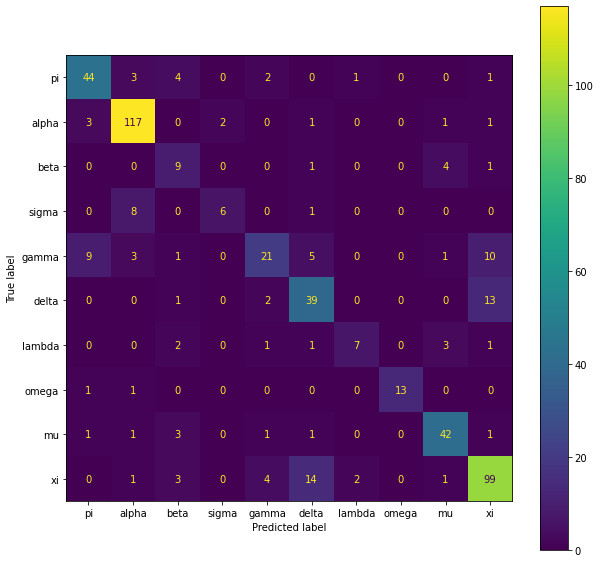

In [12]:
model_utils.show_confusion_matrix(clf_greek, Greek_X_Test, Greek_Y_Test, isGreekLetter=True)

### 2. Precision, recall, and f1-measure for each class

#### Latin Character Prediciton Model:

In [13]:
model_utils.calculate_PRF(Latin_Y_Test, Latin_Y_Pred)

,precision,recall,f1
0,0.600000,0.750000,0.666667
1,0.000000,0.000000,0.000000
2,1.000000,0.750000,0.857143
3,0.333333,0.333333,0.333333
4,0.333333,1.000000,0.500000
5,0.250000,0.500000,0.333333
6,0.500000,0.250000,0.333333
7,1.000000,0.333333,0.500000
8,1.000000,0.333333,0.500000
9,0.600000,0.750000,0.666667


#### Greek Character Prediction Model:

In [14]:
model_utils.calculate_PRF(Greek_Y_Test, Greek_Y_Pred)

,precision,recall,f1
0,0.758621,0.800000,0.778761
1,0.873134,0.936000,0.903475
2,0.391304,0.600000,0.473684
3,0.750000,0.400000,0.521739
4,0.677419,0.420000,0.518519
5,0.619048,0.709091,0.661017
6,0.700000,0.466667,0.560000
7,1.000000,0.866667,0.928571
8,0.807692,0.840000,0.823529
9,0.779528,0.798387,0.788845


### 3. Accuracy, macro-average f1 and weighted-average f1 of the model

#### Best-DT model on DS1 - Latin characters

In [15]:
print("Accuracy of best-DT model on DS1: " + str(accuracy_score(Latin_Y_Test, Latin_Y_Pred)*100)+"%")
print("Macro-average f1 of best-DT model on DS1: " + str(f1_score(Latin_Y_Test, Latin_Y_Pred, average='macro')*100)+"%")
print("Weighted-average f1 of best-DT model on DS1: " + str(f1_score(Latin_Y_Test, Latin_Y_Pred, average='weighted')*100)+"%")

Accuracy of best-DT model on DS1: 46.835443037974684%
Macro-average f1 of best-DT model on DS1: 42.45421245421245%
Weighted-average f1 of best-DT model on DS1: 44.6745027124774%


#### Best-DT model on DS2 - Greek characters

In [16]:
print("Accuracy of best-DT model on DS2: " + str(accuracy_score(Greek_Y_Test, Greek_Y_Pred)*100)+"%")
print("Macro-average f1 of best-DT model on DS2: " + str(f1_score(Greek_Y_Test, Greek_Y_Pred, average='macro')*100)+"%")
print("Weighted-average f1 of best-DT model on DS2: " + str(f1_score(Greek_Y_Test, Greek_Y_Pred, average='weighted')*100)+"%")

Accuracy of best-DT model on DS2: 76.49325626204238%
Macro-average f1 of best-DT model on DS2: 69.58140235904044%
Weighted-average f1 of best-DT model on DS2: 75.97325716179397%
